In [1]:
import torch
import ray
import gym
from IPython import display
import ray.rllib.agents.dqn as dqn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(torch.cuda.is_available())

True


In [3]:
from ray.rllib.agents import dqn

config = dqn.DEFAULT_CONFIG.copy()
config['framework'] = 'torch'
trainer = dqn.DQNTrainer(env='Breakout-v0', config=config)
policy = trainer.get_policy()
model = policy.q_model
print(model)

Install gputil for GPU system monitoring.


VisionNetwork_as_DQNTorchModel(
  (_convs): Sequential(
    (0): SlimConv2d(
      (_model): Sequential(
        (0): ZeroPad2d(padding=(2, 2, 2, 2), value=0.0)
        (1): Conv2d(4, 16, kernel_size=[8, 8], stride=(4, 4))
        (2): ReLU()
      )
    )
    (1): SlimConv2d(
      (_model): Sequential(
        (0): ZeroPad2d(padding=(1, 2, 1, 2), value=0.0)
        (1): Conv2d(16, 32, kernel_size=[4, 4], stride=(2, 2))
        (2): ReLU()
      )
    )
    (2): SlimConv2d(
      (_model): Sequential(
        (0): Conv2d(32, 256, kernel_size=[11, 11], stride=(1, 1))
        (1): ReLU()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): SlimFC(
      (_model): Sequential(
        (0): Linear(in_featur

In [4]:
import logging

from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_torch

torch, nn = try_import_torch()

logger = logging.getLogger(__name__)


class ConvNet(TorchModelV2, nn.Module):
    """Generic fully connected network."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs,
                              model_config, name)
        nn.Module.__init__(self)

        in_channels = obs_space.shape[-1]
        self._conv_layers = nn.Sequential(
            torch.nn.Conv2d(in_channels, 8, kernel_size=[7,7], padding=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(8, 16, kernel_size=[5,5], padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(16, 32, kernel_size=[3,3], padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=1),
            torch.nn.Conv2d(32, num_outputs, kernel_size=[12,12])
        )
        self._features = None
        self._num_outputs = num_outputs

        

    @override(TorchModelV2)
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs"].float().permute(0,3,1,2) #reshape input
        self._features = self._conv_layers(obs).view(-1, self._num_outputs)
        return self._features, state


In [5]:
import torch.nn as nn

import ray
from ray.rllib.agents import dqn
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2

ray.shutdown()

ModelCatalog.register_custom_model("ConvNet", ConvNet)

ray.init()
trainer = dqn.DQNTrainer(env="Breakout-v0", config={
    "framework": "torch",
    "hiddens": [256,256],
    "num_gpus": 2,
    "model": {
        "custom_model": "ConvNet",
        # Extra kwargs to be passed to your model's c'tor.
        "custom_model_config": {},
    },
})

2020-10-16 18:51:18,055	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265
2020-10-16 18:51:19,222	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [6]:

policy = trainer.get_policy()
model = policy.q_model
print(model)
for i in range(2000):
    if i % 10 == 0:
        print(trainer.train()['episode_reward_mean'])
    if i % 100 == 0:
        checkpoint = trainer.save()
        print('checkpoint saved at', checkpoint)

ConvNet_as_DQNTorchModel(
  (_conv_layers): Sequential(
    (0): Conv2d(4, 8, kernel_size=[7, 7], stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=[5, 5], stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 256, kernel_size=[12, 12], stride=(1, 1))
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (dueling_A_1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): Sli

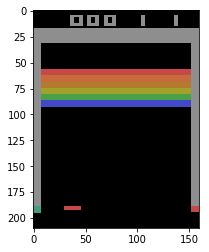

In [30]:
from IPython import display
env = trainer.workers.local_worker().env
episode_reward = 0
done = False
obs = env.reset()
for i in range(500):
    action = trainer.compute_action(obs)
    obs, reward, done, info = env.step(action)
    
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [3]:
from ray.rllib.agents import dqn

config = dqn.DEFAULT_CONFIG.copy()
config['framework'] = 'torch'
trainer = dqn.DQNTrainer(env='Breakout-ram-v0', config=config)
policy = trainer.get_policy()
model = policy.q_model
print(model)

Install gputil for GPU system monitoring.


FullyConnectedNetwork_as_DQNTorchModel(
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=4, bias=True)
      )
    )
  )
  (value_module): Sequential(
    (dueling_V_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (V):

In [7]:
import logging

from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_torch

torch, nn = try_import_torch()

logger = logging.getLogger(__name__)


class FCNet(TorchModelV2, nn.Module):
    """Generic fully connected network."""

    def __init__(self, obs_space, action_space, num_outputs, model_config,
                 name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs,
                              model_config, name)
        nn.Module.__init__(self)

        in_channels = obs_space.shape[-1]
        self._hidden_layers = nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.Tanh(),
            torch.nn.Linear(256, num_outputs),
            torch.nn.Tanh()
        )
        self._features = None
        self._num_outputs = num_outputs

        

    @override(TorchModelV2)
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs"].float()
        self._features = self._hidden_layers(obs).view(-1, self._num_outputs)
        return self._features, state

In [8]:
import torch.nn as nn

import ray
from ray.rllib.agents import dqn
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2

ray.shutdown()

ModelCatalog.register_custom_model("FCNet", FCNet)

ray.init()
trainer = dqn.DQNTrainer(env="Breakout-ram-v0", config={
    "framework": "torch",
    "hiddens": [256,256],
    "num_gpus": 2,
    "model": {
        "custom_model": "FCNet",
        # Extra kwargs to be passed to your model's c'tor.
        "custom_model_config": {},
    },
})

2020-10-18 15:25:10,291	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265
2020-10-18 15:25:11,450	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [ ]:
policy = trainer.get_policy()
model = policy.q_model
print(model)
for i in range(2000):
    if i % 10 == 0:
        print(trainer.train()['episode_reward_mean'])
    if i % 100 == 0:
        checkpoint = trainer.save()
        print('checkpoint saved at', checkpoint)

FCNet_as_DQNTorchModel(
  (_hidden_layers): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
  )
  (advantage_module): Sequential(
    (dueling_A_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (dueling_A_1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (A): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=4, bias=True)
      )
    )
  )
  (value_module): Sequential(
    (dueling_V_0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (dueling_V_1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
       